## 3. Custom Loss Functions
#### Alex Gagliano (gaglian2@mit.edu), IAIFI - January 8th, 2024

In the previous section we looked into some way to extract meaningful features (both physical and non-physical) that describe our data instances, with the hope of identifying anomalies in the reduced-dimensionality space as a downstream task. Can we modify our loss function or neural network architecture to find better anomalies? 

### 3.1: Direct Anomaly Scoring

The most straightforward way to do this is to modify our variational autoencoder from the previous section. To force the prediction of the kinds of anomalies that we'd like to find, we can tack on a feed-forward layer to our VAE that squeezes the latent vector $z$ into a single number, which we'll call our anomaly score. Then, we can modify our loss function to take an additional term that guides the score toward anomaly scores from a labeled training set. Here's how that looks in practice: 

In [1]:
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.nn import functional as F
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import pandas as pd 
import sklearn 
import random 
import torch.nn.functional as F
import hdbscan

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 99% the same network as before - the only thing that's changing is the few anomaly terms. 
class Encoder(torch.nn.Module):
    def __init__(self, input_size=7, hidden_size=400, num_layers=4, dropout=0.2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )

    def forward(self, x, lengths):
        # x: tensor of shape (batch_size, seq_length, input_size)
        # lengths: tensor of shape (batch_size), containing the lengths of each sequence in the batch

        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, hidden = self.gru(packed_x)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        return output, hidden

class Decoder(torch.nn.Module):
    def __init__(
        self, input_size=7, hidden_size=400, output_size=4, num_layers=4, dropout=0.2
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.gru = torch.nn.GRU(
            input_size,
            hidden_size,
            num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, lengths=None):
        if lengths is not None:
            packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
            packed_output, hidden = self.gru(packed_x, hidden)
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, hidden = self.gru(x, hidden)
        prediction = self.fc(output)
        return prediction, hidden

class anomaly_RNN_VAE(torch.nn.Module):
    """RNN-VAE with added anomaly scorer!"""

    def __init__(
        self, input_size=7, hidden_size=400, latent_size=50, anomaly_latent_size=20, dropout=0.2
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size 
        latent_size: int, latent z-layer size
        num_gru_layer: int, number of layers
        """
        super(anomaly_RNN_VAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.anomaly_latent_size = anomaly_latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )

        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)

        # THE ONLY NEW PIECE - a small feedforward network.
        self.fc1_anomaly = torch.nn.Linear(self.latent_size, self.anomaly_latent_size)
        self.fc2_anomaly = torch.nn.Linear(self.anomaly_latent_size, 1)

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x, lengths):
        batch_size, seq_len, feature_dim = x.shape
    
        enc_output, enc_hidden = self.enc(x, lengths)
    
        enc_h = enc_hidden[-1].to(device)  
    
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)

        #use the feed-forward network to calculate a single anomaly score from the latent vector.
        anomaly_score = self.fc2_anomaly(self.fc1_anomaly(z)).squeeze()
        
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)  
        h_ = h_.repeat(self.dec.num_layers, 1, 1) 
 
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
        
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
    
        return x_hat, mu, logvar, anomaly_score

def anomaly_ELBO(x_hat, x, mu, logvar, anomaly_score, y):
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #loss term to guide the anomaly score
    lam = 1.e5 #re-scaled to be roughly the same magnitude as the other two terms.
    anomaly_loss = lam*torch.nn.MSELoss(reduction='sum')(anomaly_score, y)
    return MSE + KLD + anomaly_loss

We'll caution that in practice, when adding in custom loss terms, it's common to modulate their strength with tuned coefficients so that your model doesn't only learn e.g., anomaly scoring without creating good light curve representations. But let's start there. Next, we need a training set. Here are my proposed anomaly scores for events in the training set, based on what I'm excited to discover in data from the Vera C. Rubin Observatory.

In [3]:
#proposed dictionary mapping of anomaly scores, from above 
anomaly_dict = {90:0.1,  #SNIa
                67:0.2,  #SNIa-91bg
                52:0.2,  #SNIax
                42:0.1,  #SNII
                62:0.5,  #SNIbc
                95:0.5, #SLSN-I
                15:0.3,  #TDE
                64:1.,    #KN
                88:0.0,  #AGN
                92:0.3,  #RRL
                65:0.3,  #M-dwarf
                16:0.0,  #EB
                53:0.5,  #Mira
                6:1.} #muLens-Single

As before, let's pre-process our datasets and train our model. 

In [4]:
labeled_dataset = pd.read_csv("../data/plasticc_train_lightcurves.csv")
labeled_dataset_detected = labeled_dataset[labeled_dataset['detected_bool'] == True]
labeled_metadata =  pd.read_csv("../data/plasticc_train_metadata.csv")
labeled_metadata['anomaly_score'] = labeled_metadata['true_target'].map(anomaly_dict)

#set up a random seed so that we can always keep the same train and val sets
np.random.seed(2383)
N = len(labeled_dataset_detected)
indices = np.random.permutation(N)
train_idxs = indices[:int(0.8*N)]
val_idxs = indices[int(0.8*N):]

lcs_train = labeled_dataset_detected.iloc[train_idxs]
lcs_val = labeled_dataset_detected.iloc[val_idxs]
lcs_test = pd.read_csv("../data/plasticc_test_lightcurves_01.csv")

dftest_metadata = pd.read_csv("../data/plasticc_test_metadata.csv")
lcs_train_wMetadata = lcs_train.merge(labeled_metadata)
lcs_val_wMetadata = lcs_val.merge(labeled_metadata)

lcs_test = pd.read_csv("../data/plasticc_test_lightcurves_02.csv")
lcs_test_detected = lcs_test[lcs_test['detected_bool'] == True]
lcs_test_wMetadata = lcs_test_detected.merge(dftest_metadata)

In [5]:
def preprocess_lcs(df, set='train'):
    zpt = 27.5 #the zeropoint of the survey
    df = df[df['flux'] > 0].copy(deep=True) #subset to only positive fluxes

    df.loc[df['hostgal_photoz'] == 0, 'distmod'] = 28 #correponding to a redshift of ~0.001
    df['absolute_mag'] = zpt - 2.5*np.log10(df['flux'].values) - df['distmod']
    df['absolute_mag'] = -df['absolute_mag'] #flip the sign, so that magnitudes increase for brighter events
    #this is an annoying aspect of astronomy...
    df['mag_err'] = np.clip(1.0857 * np.abs(df['flux_err'].values/df['flux'].values), a_min=0, a_max=1.0)

    # Get the central wavelengths of each filter in microns
    # 0-6 correspond to Rubin's ugrizY
    central_wvs = {0:3.751, 1:4.741, 2:6.172, 3:7.501, 4:8.679, 5:9.712}
    oids = np.unique(df['object_id'])

    data = []
    target_class = []
    oids_used = []
    anomaly_score = []
    for oid in oids: 
        lc = df[df['object_id'] == oid].copy(deep=True)
        lc['wv'] = lc['passband'].map(central_wvs)
        lc['phase'] = lc['mjd'] - np.nanmin(lc['mjd'])
        lc = lc[lc['phase'] < 50].copy(deep=True)
        
        if len(lc) > 100:
            lc = lc.sample(100)
            
        data.append(lc[['phase', 'absolute_mag', 'mag_err', 'wv', 'mwebv', 'hostgal_photoz', 'hostgal_photoz_err']].values)
        target_class.append(lc['true_target'].values[0])
        if set != 'test':
            anomaly_score.append(lc['anomaly_score'].values[0])
        else:
            #since we don't have anomaly scores for the test set (yet) 
            anomaly_score.append(-1)
    return target_class, data, anomaly_score

In [6]:
#this part might will take ~10 minutes - there are a LOT of test light curves
train_labels, train_data, train_anomalyscore = preprocess_lcs(lcs_train_wMetadata, 'train')
val_labels, val_data, val_anomalyscore = preprocess_lcs(lcs_val_wMetadata, 'val')
test_labels, test_data, test_anomalyscore = preprocess_lcs(lcs_test_wMetadata, 'test')

In [12]:
def collate_fn(batch):
    data, targets, anomaly_scores, lengths = zip(*batch)

    # Convert sequences to tensors and pad them
    sequences = [torch.tensor(d, dtype=torch.float32) for d in data]
    padded_sequences = pad_sequence(sequences, batch_first=True).to(device)

    # Convert other data to tensors
    anomaly_scores = torch.tensor(anomaly_scores, dtype=torch.float32).to(device)
    targets = torch.tensor(targets, dtype=torch.float32).to(device)
    lengths = torch.tensor(lengths)
    
    return padded_sequences, targets, anomaly_scores, lengths
    
class LCDataset(Dataset):
    def __init__(self, data, targets, anomaly_scores, transform=None):
        self.data = data
        self.targets = targets
        self.anomaly_scores = anomaly_scores
        self.lengths = [len(seq) for seq in data]
        self.transform = transform
        
    def __getitem__(self, index):
        data = self.data[index]
        targets = self.targets[index]
        anomaly_scores = self.anomaly_scores[index]
        lengths = self.lengths[index]

        if self.transform:
            data = self.transform(data)

        return data, targets, anomaly_scores, lengths

    def __len__(self):
        return len(self.data)

In [13]:
train_ds = LCDataset(train_data, train_labels, train_anomalyscore)
train_loader = DataLoader(
    train_ds,
    drop_last=True,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)

val_ds = LCDataset(val_data, val_labels, val_anomalyscore)
val_loader = DataLoader(
    val_ds,
    drop_last=True,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=torch.cuda.is_available()
)


test_ds = LCDataset(test_data, test_labels, test_anomalyscore)
test_loader = DataLoader(
    test_ds,
    drop_last=True,
    batch_size=32,
    num_workers=0,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True
)

In [14]:
model = anomaly_RNN_VAE()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1.e-4)

#iterate through 10 training epochs
validation_losses = []
training_losses = []

nepochs = 10

print("Beginning training of anomaly scorer...")
for epoch in range(0, nepochs):
    # train
    model.train()
    train_loss = 0
    for x, y, anomaly_score, lengths in train_loader:
        x = x.to(device)
        x_hat, mu, logvar, predicted_score = model(x, lengths)
        loss = anomaly_ELBO(x_hat, x, mu, logvar, anomaly_score, predicted_score)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()

        # clip gradients to keep them at a reasonable size
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y, anomaly_score, lengths in val_loader:
            x = x.to(device)
            x_hat, mu, logvar, predicted_score = model(x, lengths)
            valid_loss += anomaly_ELBO(x_hat, x, mu, logvar, anomaly_score, predicted_score)

    validation_losses.append(valid_loss / len(val_loader.dataset))
    training_losses.append(train_loss / len(train_loader.dataset))

    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.2f} | Valid: {valid_loss / len(val_loader.dataset):.2f}')

Beginning training of anomaly scorer...
 Epoch 0 | Train: 13934.82 | Valid: 4878.77
 Epoch 1 | Train: 6822.68 | Valid: 4584.85
 Epoch 2 | Train: 6414.86 | Valid: 4757.11
 Epoch 3 | Train: 6252.69 | Valid: 4625.16
 Epoch 4 | Train: 6109.80 | Valid: 4628.79
 Epoch 5 | Train: 6061.94 | Valid: 4487.13
 Epoch 6 | Train: 5990.36 | Valid: 4617.86
 Epoch 7 | Train: 6023.13 | Valid: 4592.17
 Epoch 8 | Train: 5894.19 | Valid: 4544.07
 Epoch 9 | Train: 5811.46 | Valid: 4471.74


In [15]:
# Save/load the model weights if you don't want to worry about training
torch.save(model.state_dict(), '../models/RNN_VAE_AnomalyScorer_10Epochs.h5')
#model.load_state_dict(torch.load('../models/RNN_VAE_AnomalyScorer_10Epochs.h5'))

We've only trained for 10 epochs, but let's see how well we do on the validation set anyway. 

In [26]:
predicted_list = []
anomaly_list = []
y_list = []
with torch.no_grad():
    model.eval()
    valid_loss = 0
    for x, y, anomaly_score, lengths in val_loader:
        x = x.to(device)
        x_hat, mu, logvar, predicted_score = model(x, lengths)
        predicted_list.append(predicted_score)
        anomaly_list.append(anomaly_score)
        y_list.append(y)

y_list = torch.cat(y_list).cpu().numpy()
anomaly_list = torch.cat(anomaly_list).cpu().numpy()
predicted_list = torch.cat(predicted_list).cpu().numpy()

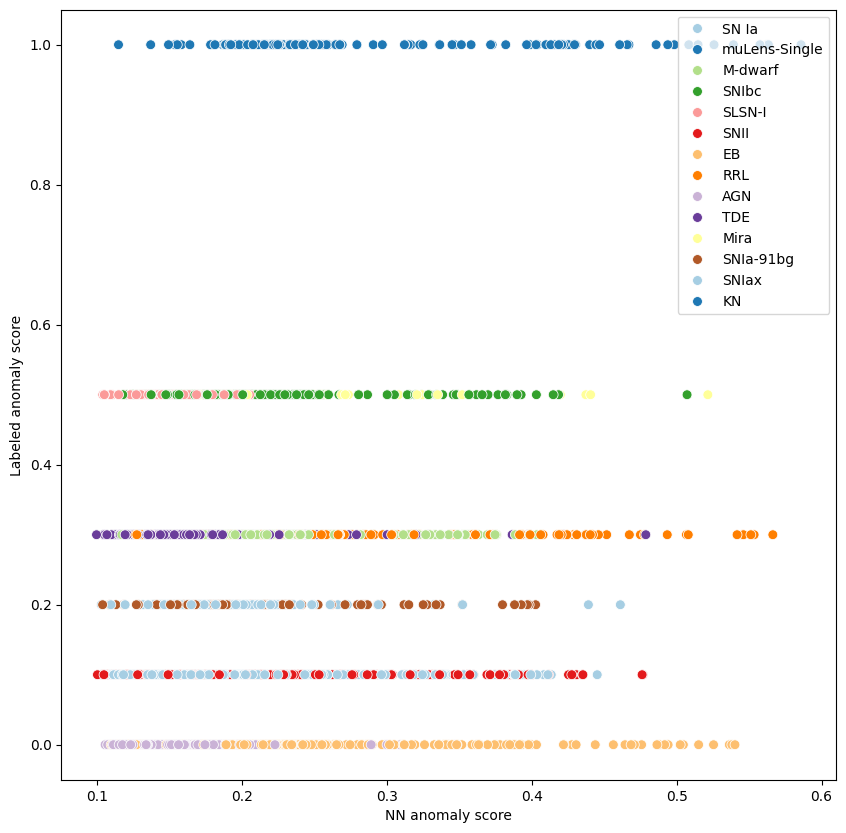

In [27]:
model_nums = {90:'SN Ia', 67:'SNIa-91bg', 52:'SNIax', 42:'SNII', 62:'SNIbc', 95:'SLSN-I', 15:'TDE', 64:'KN', 88:'AGN', 92:'RRL', 65:'M-dwarf', 16:'EB', 53:'Mira', 6:'muLens-Single', 991:'muLens-Binary', 992:'ILOT', 993:'CaRT', 994:'PISN', 995:'muLens-String'}
y_names = np.vectorize(model_nums.get)(y_list)

plt.figure(figsize=(10,10))
sns.scatterplot(x=predicted_list, y=anomaly_list, hue=y_names, s=50, palette='Paired')
plt.xlabel("NN anomaly score");
plt.ylabel("Labeled anomaly score");

In [28]:
# At least they're correlated!
print("%.2f"%np.corrcoef(predicted_list, anomaly_list)[0,1])

0.20


In [29]:
# What is the anomaly score of events in our test set? 
score_list = []
y_list = []

with torch.no_grad():
    model.eval()

    for x, y, _, lengths in test_loader:
        x = x.to(device)
        x_hat, mu, logvar, score = model(x, lengths)        
        score_list.append(score)
        y_list.append(y)

score_list = torch.cat(score_list).cpu().numpy()
y_list = torch.cat(y_list).cpu().numpy()

Text(0, 0.5, 'Number of Transients')

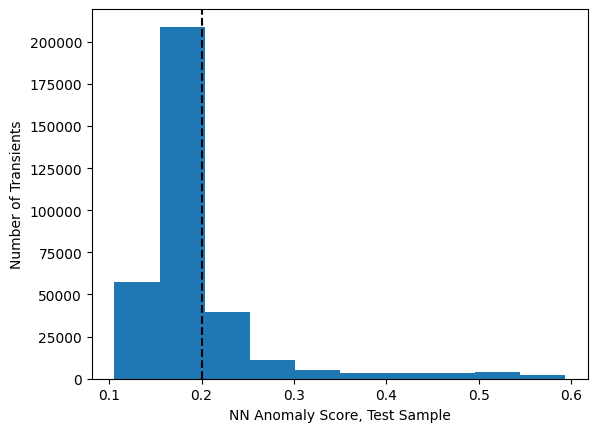

In [30]:
#going conservative, let's look at the events with score > 0.2:
plt.hist(score_list);
plt.axvline(x=0.2, ls='--', zorder=10, c='k')
plt.xlabel("NN Anomaly Score, Test Sample")
plt.ylabel("Number of Transients");

In [31]:
print(len(y_names))

5792


In [32]:
y_names = np.vectorize(model_nums.get)(y_list)
Counter(y_names[score_list > 0.2])

Counter({'M-dwarf': 6873,
         'SN Ia': 24028,
         'EB': 4982,
         'RRL': 18684,
         'SNII': 15316,
         'SNIbc': 5742,
         'ILOT': 54,
         'SNIax': 1393,
         'SNIa-91bg': 1587,
         'AGN': 635,
         'Mira': 135,
         'CaRT': 285,
         'SLSN-I': 163,
         'TDE': 74,
         'muLens-Single': 101,
         'muLens-Binary': 43,
         'PISN': 15,
         'KN': 8})

What's exciting is that, out of >338k total test events, we found 54/176 Intermediate-Luminosity Optical Transients (ILOTs), 285/953 Calcium-Rich Transients (CaRTs), 2/115 PISNe, and 43/44 binary microlensing events (muLens-Binary) that weren't present in the training set! But there are lots of normal things too (24k SNe Ia...). Let's define an anomaly in this case as 
* Kilonovae and single-lens microlensing events from our training set (the two with the highest labeled anomaly scores), and 
* The four classes in the test set that aren't in the training set (ILOT, CaRT, PISN, and muLens-Binary).
 
and compute some performance metrics. 

In [33]:
#performance metrics here
pred_class = np.array(['Not Anomaly']*len(y_names))
pred_class[score_list > 0.2] = 'Anomaly'

true_class = np.array(['Not Anomaly']*len(y_names))
true_class[np.isin(y_names, ['PISN', 'KN', 'ILOT', 'muLens-Binary', 'muLens-Single', 'CaRT'])] = 'Anomaly'

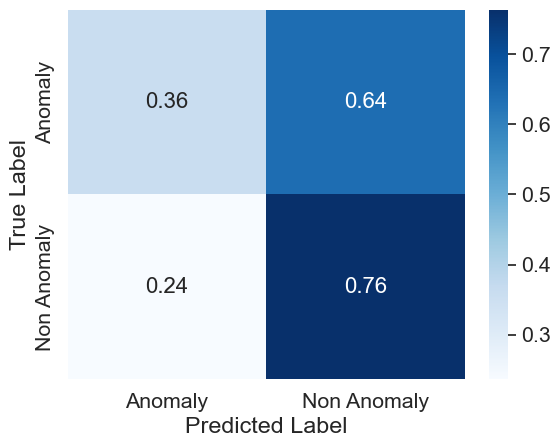

In [34]:
labels = ["Anomaly", "Non Anomaly"]
df = pd.DataFrame(confusion_matrix(true_class, pred_class, normalize='true'), index=labels, columns=labels)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap='Blues');
plt.ylabel("True Label");
plt.xlabel("Predicted Label");

The confusion matrix (above) gives us a better view of our performance than accuracy alone might. This tells us the completeness/recall of our method: we are correctly recovering 36% of anomalies (top left) and 76% of non-anomalies (bottom right). 

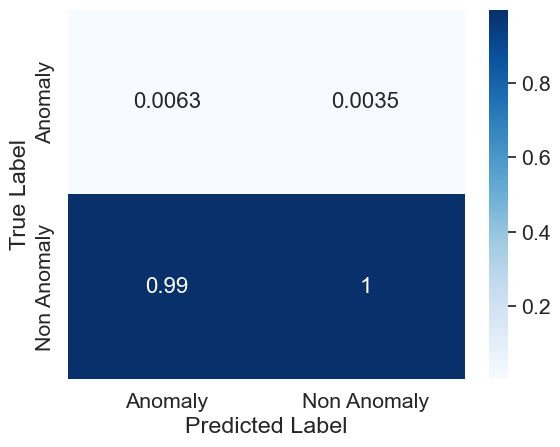

In [35]:
df = pd.DataFrame(confusion_matrix(true_class, pred_class, normalize='pred'), index=labels, columns=labels)
sns.set(font_scale=1.4) # for label size
sns.heatmap(df, annot=True, annot_kws={"size": 16}, cmap='Blues');
plt.ylabel("True Label");
plt.xlabel("Predicted Label");

This tells us the purity/precision of our samples - 99% of our labeled anomalies are not anomalies, which is...not great. This can also be seen in the performance metrics below:

In [40]:
print(sklearn.metrics.classification_report(true_class, pred_class))

              precision    recall  f1-score   support

     Anomaly       0.01      0.36      0.01      1400
 Not Anomaly       1.00      0.76      0.86    336840

    accuracy                           0.76    338240
   macro avg       0.50      0.56      0.44    338240
weighted avg       0.99      0.76      0.86    338240



We saw from above that most of the events contaminating the anomalous sample were RR-Lyrae and SNe Ia. We can change our scoring to rank them as less anomalous in the training set, train for longer, or find a way to augment the training set with additional anomalous events. See if you can do a bit better!

### 3.1: Contrastive Learning

There are also more informed ways to incorporate our labels from the training set (without having to construct subjective anomaly scores). One technique that is increasingly employed in anomaly detection (and ML at large) is _contrastive learning_, in which the embedding space is guided to minimize the distance between similar events and maximize the distance between different events. A common loss is the _triplet loss_, where distances are considered between the _anchor_ (an event in question), a _negative_ (in this case, an event of a different class), and a _positive_ (an event of the same class). To make this work, we'll need a routine to split up a batch into these three categories: 

In [41]:
def select_triplets(batch, labels):
    anchors, positives, negatives = [], [], []

    for i, anchor in enumerate(batch):
        anchor_label = labels[i]

        #if we fail, it'll be because we have no matching events within a batch. Remember, this is a highly imbalanced traininng dataset!
        try:
            # Positive: different instance, same label
            positive = random.choice([b for j, b in enumerate(batch) if labels[j] == anchor_label and j != i])
    
            # Negative: any instance with a different label
            negative = random.choice([b for j, b in enumerate(batch) if labels[j] != anchor_label])
        except IndexError:
            continue

        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

    return torch.stack(anchors), torch.stack(positives), torch.stack(negatives)

Next, we'll need a custom loss function that incorporates the calculation of the distance between these triplets:

In [42]:
def contrastive_elbo(x_hat, x, mu, logvar, anchors, positives, negatives):
    
    MSE = torch.nn.MSELoss(reduction='sum')(x_hat, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    #loss to group similar phenomena
    lam = 1. # custom weighting, unity for now
    distance_positive = F.pairwise_distance(anchors, positives)
    distance_negative = F.pairwise_distance(anchors, negatives)
    margin = 0.01
    contrastive_loss = F.relu(distance_positive - distance_negative + margin).mean()
    
    return MSE + KLD + lam*contrastive_loss

As before, we'll define our RNN VAE:

In [47]:
class RNN_VAE(torch.nn.Module):
    """Vanilla RNN-VAE"""

    def __init__(
        self, input_size=7, hidden_size=400, latent_size=50, dropout=0.2
    ):
        """
        input_size: int, batch_size x sequence_length x input_dim
        hidden_size: int, output size 
        latent_size: int, latent z-layer size
        num_gru_layer: int, number of layers
        """
        super(RNN_VAE, self).__init__()
        self.device = device

        # dimensions
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.num_layers = 4
        self.dropout = dropout
        
        self.enc = Encoder(input_size=input_size, hidden_size=hidden_size, num_layers=self.num_layers, dropout=self.dropout)
        
        self.dec = Decoder(
            input_size=latent_size,
            output_size=input_size,
            hidden_size=hidden_size,
            dropout=self.dropout,
            num_layers=self.num_layers,
        )

        self.fc21 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc22 = torch.nn.Linear(self.hidden_size, self.latent_size)
        self.fc3 = torch.nn.Linear(self.latent_size, self.hidden_size)

    def reparameterize(self, mu, logvar):
        if self.training:
            return mu + torch.randn(mu.shape).to(device)*torch.exp(0.5*logvar)
        else:
            return mu

    def forward(self, x, lengths):
        batch_size, seq_len, feature_dim = x.shape
    
        enc_output, enc_hidden = self.enc(x, lengths)
    
        enc_h = enc_hidden[-1].to(device)  
    
        mu = self.fc21(enc_h)
        logvar = self.fc22(enc_h)
        z = self.reparameterize(mu, logvar)
        
        h_ = self.fc3(z)
        h_ = h_.unsqueeze(0)  
        h_ = h_.repeat(self.dec.num_layers, 1, 1) 
 
        z = z.repeat(1, seq_len, 1)
        z = z.view(batch_size, seq_len, self.latent_size).to(device)
        
        hidden = h_.contiguous()
        x_hat, hidden = self.dec(z, hidden)
    
        return x_hat, mu, logvar

In [48]:
model = RNN_VAE()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=1.e-4)

#iterate through 10 training epochs
validation_losses = []
training_losses = []

nepochs = 10

print("Beginning training of contrastive RNN-VAE...")
for epoch in range(0, nepochs):
    # train
    model.train()
    train_loss = 0
    for x, y, _, lengths in train_loader:
        x = x.to(device)
        anchors, positives, negatives = select_triplets(x, y)
        x_hat, mu, logvar = model(x, lengths)
        loss = contrastive_elbo(x_hat, x, mu, logvar, anchors, positives, negatives)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()

        # clip gradients to keep them at a reasonable size
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

    # validate
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for x, y, _, lengths in val_loader:
            x = x.to(device)
            anchors, positives, negatives = select_triplets(x, y)
            x_hat, mu, logvar = model(x, lengths)
            valid_loss += contrastive_elbo(x_hat, x, mu, logvar, anchors, positives, negatives)

    validation_losses.append(valid_loss / len(val_loader.dataset))
    training_losses.append(train_loss / len(train_loader.dataset))

    print(f' Epoch {epoch} | Train: {train_loss / len(train_loader.dataset):.2f} | Valid: {valid_loss / len(val_loader.dataset):.2f}')

Beginning training of contrastive RNN-VAE...
 Epoch 0 | Train: 3841.34 | Valid: 934.45
 Epoch 1 | Train: 2494.14 | Valid: 866.83
 Epoch 2 | Train: 2412.81 | Valid: 797.66
 Epoch 3 | Train: 2329.15 | Valid: 764.43
 Epoch 4 | Train: 2228.03 | Valid: 724.16
 Epoch 5 | Train: 2069.77 | Valid: 655.55
 Epoch 6 | Train: 2033.93 | Valid: 637.24
 Epoch 7 | Train: 1972.58 | Valid: 679.83
 Epoch 8 | Train: 2000.96 | Valid: 604.21
 Epoch 9 | Train: 1933.08 | Valid: 593.41


In [49]:
# Save/load the model weights if you don't want to worry about training
torch.save(model.state_dict(), '../models/RNN_VAE_ContrastiveLoss_10Epochs.h5')
#model.load_state_dict(torch.load('../models/RNN_VAE_ContrastiveLoss_10Epochs.h5'))

Is our embedding space now more useful for pullling out anomalies? Let's find out, now with all light curves in the first test batch! 

In [52]:
mu_list = []
y_list = []

with torch.no_grad():
    model.eval()

    for x, y, _, lengths in test_loader:
        x = x.to(device)
        x_hat, mu, logvar = model(x, lengths)        
        mu_list.append(mu)
        y_list.append(y)

mu_list = torch.cat(mu_list).cpu().numpy()
y_list = torch.cat(y_list).cpu().numpy()

In [57]:
def getOutliers(y_list, outlier_scores, asc=False):
    # get the names of the transients
    y_names = np.vectorize(model_nums.get)(y_list)
        
    idx_sorted = np.argsort(outlier_scores)

    #do larger numbers correspond to a higher anomaly score?
    #if so, flip
    if asc: 
        idx_sorted = idx_sorted[::-1]
        
    #get the top 10 outliers and the top 100 inliers
    outliers = y_names[idx_sorted][0:100]
    inliers = y_names[idx_sorted][-100:]
    
    c =  Counter(outliers)
    c_ranked = [(i, c[i]) for i, count in c.most_common()]
    print("Composition of labeled outliers:",c_ranked)
    
    c =  Counter(inliers)
    c_ranked = [(i, c[i]) for i, count in c.most_common()]
    print("Composition of labeled inliers:", c_ranked)

clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
clusterer.fit(mu_list)
outlier_scores = clusterer.outlier_scores_

getOutliers(y_list, outlier_scores, asc=True)

Composition of labeled outliers: [('SN Ia', 36), ('M-dwarf', 25), ('RRL', 15), ('SNII', 11), ('EB', 6), ('AGN', 3), ('SNIbc', 2), ('TDE', 1), ('SLSN-I', 1)]
Composition of labeled inliers: [('SN Ia', 50), ('SNII', 31), ('RRL', 9), ('AGN', 3), ('SNIax', 3), ('M-dwarf', 2), ('SNIbc', 2)]


This is training over 10 epochs and not finding an anomaly score cutoff. Can you do better with a more sophisticated training routine? 